# A3a Exploration
Finn Hittson - fxh157  
CSDS 464  
Due: March 23rd, 2023

## Recap
For my research extension I am trying to build a beat detection system. This is an implementation of an algorithm proposed in the paper *Streamlined Tempo Estimation Based on Autocorrelation and Cross-correlation With Pulses*, written by Graham Percival and George Tazanetakis.  
In my previous progress report I had completed an implementation of the first step of the algorithm; Generate onset signal strength (OSS).

## A3a Progress
A problem I am struggling with is replecating the figures presented in the paper which is my main way of checking how correct my code is. In my last report I was unable to reproduce the Log Power Spectrum figured and those after it. After doing some of my own research outside of the paper and seeking help from Professor Lewicki I create a plot that closely resembles the one reported in the paper.  
A new issue that is now bottlenecking my procress is the flux computation check. My plot of the flux does not resemble the flux plot in the paper. I have checked other sources for flux computation and the preceeding steps which all suggest that my work is correct so I suspect that the authors performed extra steps which are not recorded in their published paper. I am still experimenting with the steps leading up to the flux computation to see if I can still replecate their plot.  
My FIR filter implementation in my last progress report was implemented incorrectly. The shift amount was half of the window size so I decreased it to shift by one index thereby increasing the filters resolution. I am confident in my filter implementation since the plot it produces is a smoothed version of the flux, even though the flux computation is incorrect. I suspect that if I can fix my flux computation the low pass filter plot will immediatly follow afterwards.  
  
The next part of the algorithm I have implemented is the Beat Period Detection (BPD) portion. This consists of $5$ steps
1. Overlap: segment the input OSS signal into overlapping frames of length $2048$ with hop size $128$ samples.  
2. Generalized autocorrelation: The authors utilized a "generalized autocorrelation" function in a separate papter which is defined as  
$$
A_m(t)=DFT^{-1}(|DFT(OSS(m))|^c)
$$ $DFT$ is the discrete Fourier transform and $DFT^{-1}$ is the inverse discrete Fourier transform. $OSS(m)$ is the input signal index my $m$ and $c$ is a parameter that controsl the frequency comain compression. A typical value for $c$ is $0.5$.  
3. Enhance harmonics: Since the autocorrelation $A_m$ has peaks corresponding to integer multiples of the underlying tempo and dominant periods related to rhythmic subdivisions, this steps boosts these peaks with the following equation.  
$$
EAC_m(t)=A_m(t)+A_m(2\cdot t)+A_m(4\cdot t)
$$
4. Pick Peaks: The top ten peaks between the minimum and maximum lag, 98 BPM and 414BPM, are selected as the tempo candidates.  
5. Evaluate pulse trains: Tempo candiates are evaluated by correlating the OSS signal with an ideal expected pulse train that is shifted by different time amounts. This is done by cross correlation between the two inputs.  
  
I have implemented steps $1$ through $4$. The overlap steps was completed reusing the code from the OSS overlap step. The generalized autocorrelation was completed using NumPy's discrete Fourier transform functions. Enhancing the harmonics is as simple as adding values of the autocorrelation onto itself. Picking the top ten peaks was done by locating all local maximums and then sorting to find the ten largest and their corresponding indices. All of these results are outlined pictorially below.

## Next Steps
Going forward I am going to implement the final step of BPD which evaluates the pulse trains with ideal pulse trains using signal cross correlation. I am also continuing my own research as to why my flux plot is different then the authors. If time permits between this progress report and the next, I will also start the final step of the algorithm.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import numpy as np
import math
import IPython

import OSS as oss
import BPD as bpd

### OSS

#### 1. Overlap

In [2]:
filepath = "ballroom.wav"
sr, data = oss.read_wav(filepath)
print(f"sampling rate: {sr}Hz")
print(f"audio length: {round(len(data)/sr, 3)} seconds")
IPython.display.Audio(filepath)

sampling rate: 44100Hz
audio length: 31.788 seconds


calculated frame count: 10944 frames
returned frame count: 10944 frames


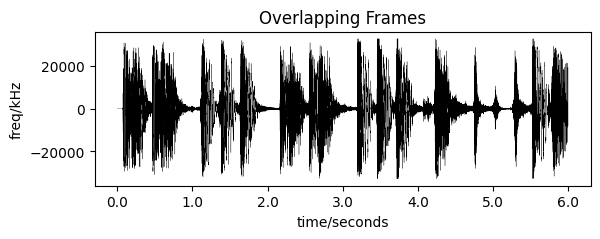

In [3]:
framesize = 1024
hop = 128
print(f"calculated frame count: {1+math.floor((len(data)-framesize)/hop)} frames")
frames = oss.get_frames(data=data, framesize=framesize, hop=hop)
print(f"returned frame count: {len(frames)} frames")
frames6 = frames[:2059]
oss.plot_frames(frames=frames6, sr=44100, framesize=1024, hop=128, title="Overlapping Frames")

Target plot for overlap.  
  
![](target_images/overlap_oss.jpg)

#### 2. Log Power Spectrum

In [4]:
tappered_frames = oss.hamming_window(frames)
tappered_frames6 = oss.hamming_window(frames6)

# compute the discrete fourier transform of the frames
fft_frames = scipy.fft.fft(tappered_frames)
fft_frames6 = scipy.fft.fft(tappered_frames6)

In [5]:
log_power = np.array(oss.comp_log_power(fft_frames))
log_power6 = np.array(oss.comp_log_power(fft_frames6))

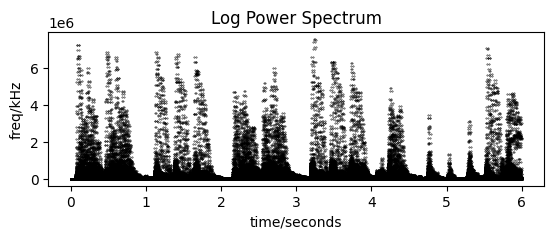

In [6]:
oss.plot_log_spectrum(fft_frames6, framesize=1024, hop=128, sr=44100)

Target plot for Log Power Spectrum.  
  
![](target_images/log_power_spectrum_oss.jpg)

#### 3. Flux

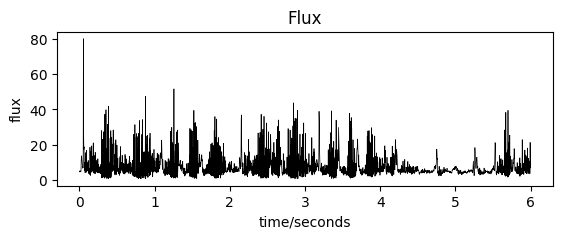

In [7]:
flux = oss.get_flux(log_power, fft_frames)
flux6 = oss.get_flux(log_power6, fft_frames6)
oss.plot_flux(flux6)

Target plot for Flux.  
  
![](target_images/flux_oss.jpg)

#### 4. Low-pass Filter

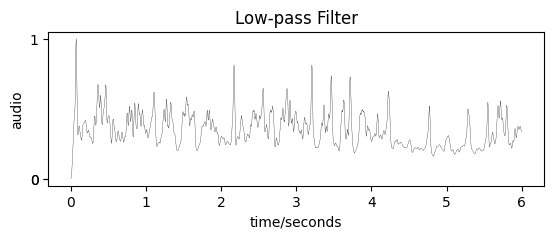

In [8]:
filtered_signal = oss.low_pass_filter(flux=flux)
filtered_signal6 = oss.low_pass_filter(flux=flux6)
oss.plot_signal(filtered_signal6, sr=344.5, title="Low-pass Filter")

Target plot for Low-pass Filter.  
  
![](target_images/flux_oss.jpg)

### Beat Period Detection

#### 1. Overlap

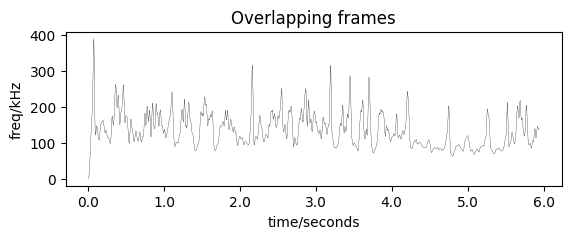

In [9]:
frames = bpd.overlap(data=filtered_signal, framesize=2048, hop=128)
oss.plot_frames(frames=frames[0], sr=344.5, framesize=2048, hop=128, title="Overlapping frames")

Target plot for Overlap.  
  
![](target_images/overlap_bpd.jpg)

#### 2. Generalized Autocorrelation

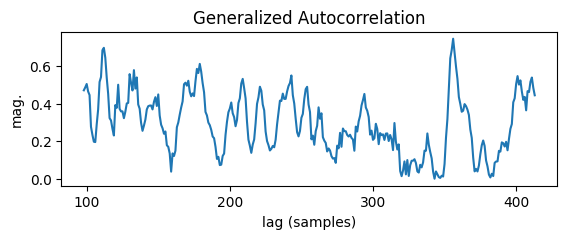

In [10]:
A = bpd.generalized_autocorrelation(frames=frames, c=0.5)
bpd.plot_correlation(A=A, title="Generalized Autocorrelation")

Target plot for Generalized Autocorrelation.  
  
![](target_images/generalized_autocorrelation_bpd.jpg)

#### 3. Enhance Harmonics

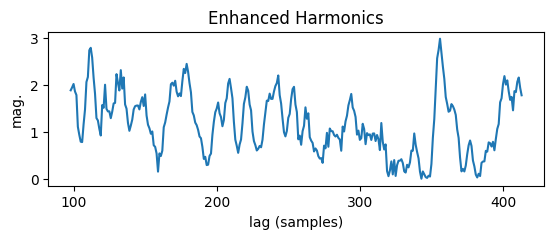

In [11]:
EAC = bpd.enhance_harmonics(A=abs(A))
bpd.plot_correlation(A=EAC, title="Enhanced Harmonics")

Target plot for Enhanced Harmonics.  
  
![](target_images/enhance_harmonics_bpd.jpg)

#### 4. Pick Peaks

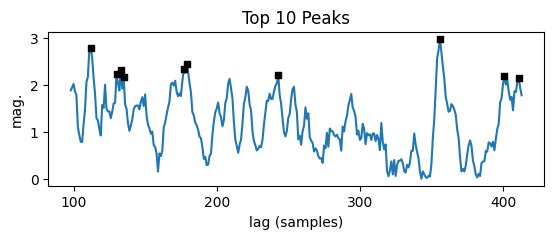

In [12]:
indices, values = bpd.pick_peaks(EAC)
bpd.plot_correlation(A=EAC, indices=indices, values=values, title="Top 10 Peaks")

Target plot for Pick Peaks.  
  
![](target_images/pick_peaks_bpd.jpg)